In [1]:
import numpy as np
import pandas as pd

#Visualization
import matplotlib.pyplot as plt

##Preprocessing
from sklearn.preprocessing import StandardScaler, MinMaxScaler, Normalizer,OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import r2_score,max_error

#test train split
from sklearn.model_selection import train_test_split
import scipy.sparse.linalg as ll

#dimension reduction
from scipy.interpolate import BSpline

In [2]:
train = pd.read_csv("train.csv")
y = train["SalePrice"]
train = train.drop(columns=["SalePrice"])
test = pd.read_csv("test.csv")

#These columns are no important because of pooling
train = train.drop(columns=["Id","YrSold","YearBuilt", "YearRemodAdd", "YrSold", "MoSold"])

print(train.shape, test.shape, y.shape)

(1460, 75) (1459, 80) (1460,)


### Training data set contains 1460 rows and 80 columns
### Test data set contains 1460 rows and 80 columns
### Y contain response variable [SalePrice]

## Understanding Data

In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 75 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   int64  
 1   MSZoning       1460 non-null   object 
 2   LotFrontage    1201 non-null   float64
 3   LotArea        1460 non-null   int64  
 4   Street         1460 non-null   object 
 5   Alley          91 non-null     object 
 6   LotShape       1460 non-null   object 
 7   LandContour    1460 non-null   object 
 8   Utilities      1460 non-null   object 
 9   LotConfig      1460 non-null   object 
 10  LandSlope      1460 non-null   object 
 11  Neighborhood   1460 non-null   object 
 12  Condition1     1460 non-null   object 
 13  Condition2     1460 non-null   object 
 14  BldgType       1460 non-null   object 
 15  HouseStyle     1460 non-null   object 
 16  OverallQual    1460 non-null   int64  
 17  OverallCond    1460 non-null   int64  
 18  RoofStyl

In [4]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1459 non-null   int64  
 1   MSSubClass     1459 non-null   int64  
 2   MSZoning       1455 non-null   object 
 3   LotFrontage    1232 non-null   float64
 4   LotArea        1459 non-null   int64  
 5   Street         1459 non-null   object 
 6   Alley          107 non-null    object 
 7   LotShape       1459 non-null   object 
 8   LandContour    1459 non-null   object 
 9   Utilities      1457 non-null   object 
 10  LotConfig      1459 non-null   object 
 11  LandSlope      1459 non-null   object 
 12  Neighborhood   1459 non-null   object 
 13  Condition1     1459 non-null   object 
 14  Condition2     1459 non-null   object 
 15  BldgType       1459 non-null   object 
 16  HouseStyle     1459 non-null   object 
 17  OverallQual    1459 non-null   int64  
 18  OverallC

## Data Cleaning

### Preprocessing
### Imputing missing value, USE OrdinalEncoder for objects, SimpleImputer for continuous values

(1460, 43) (1460, 32) (1460, 75)


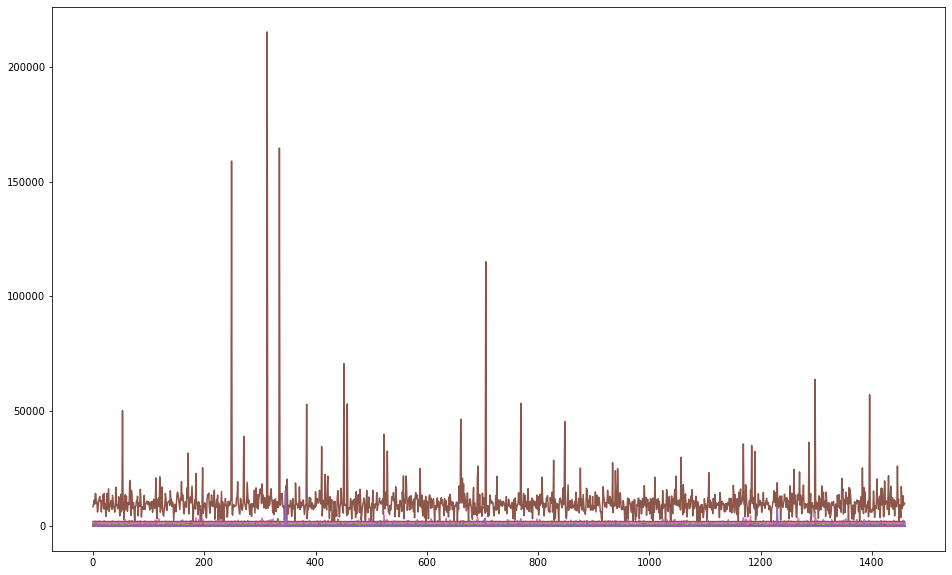

In [5]:
enc = OrdinalEncoder(encoded_missing_value=-1)
imp = SimpleImputer(missing_values=np.nan, strategy='mean')

train_calssify = enc.fit_transform(train[train.columns[train.dtypes == object]])
train_continuous = imp.fit_transform(train[train.columns[train.dtypes != object]])
train_processed = np.hstack((train_calssify, train_continuous))


print(train_calssify.shape, train_continuous.shape, train_processed.shape)

fig, ax = plt.subplots(figsize=(16, 10))    
plt.plot(train_processed)
plt.show()

## Not quite there yet
## Scale data

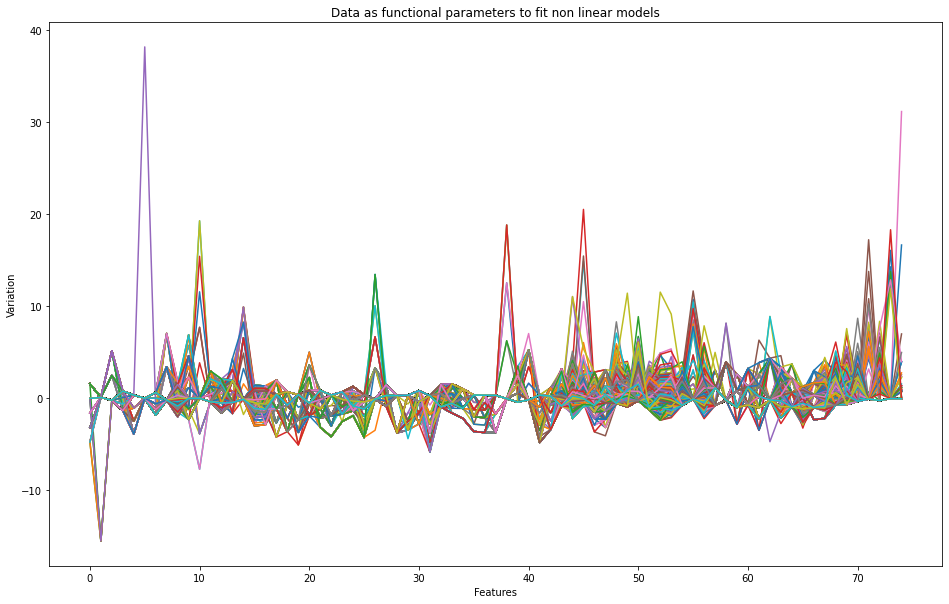

In [6]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler().fit(train_processed.copy())
train_scaled = scaler.transform(train_processed.copy())
fig, ax = plt.subplots(figsize=(16, 10))    
plt.plot(train_scaled.T)
plt.title("Data as functional parameters to fit non linear models")
plt.xlabel("Features")
plt.ylabel("Variation")
plt.show()

## Dimension Reduction and Feature Extraction via Bsplines

In [7]:
def get_bsplines(X, knots, degree):
    nKnots = knots.shape[0]
    lo = min(D[0], knots[0])
    hi = max(D[-1], knots[-1])
    augmented_knots = np.append(
    np.append([lo]*degree, knots), [hi]*degree)
    ##### Set degree = 0 for natural cubic splines i.e.  K+1
    ##### Set degree = number for B splines i.e.  K+d
    DOF = nKnots + degree +1 # DOF = K+M, M = degree+1
    spline = BSpline(augmented_knots, np.eye(DOF),
                     degree, extrapolate=False)
    B = spline(D)[:,:-1]
    return B

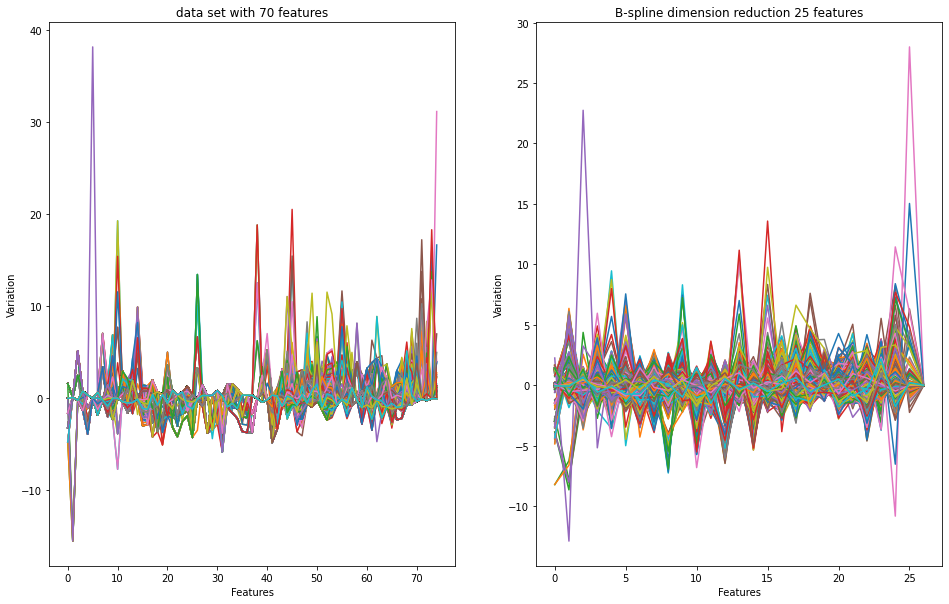

In [8]:
#more knots better curve fitting
knot = 25 
X = train_scaled.copy()
n = train_scaled.shape[1]
D = np.linspace(0, 1, n)
knots = np.linspace(0, 1, knot)
degree = 2
B = get_bsplines(D, knots, degree)
Bcoef = np.linalg.lstsq(B, X.T, rcond=None)[0].T 
fig, ax = plt.subplots(figsize=(16, 10))   

plt.subplot(1, 2, 1)

plt.xlabel("Features")
plt.ylabel("Variation")
plt.title("data set with 70 features")
plt.plot(train_scaled.T)

plt.subplot(1, 2, 2)
plt.title("B-spline dimension reduction 25 features")
plt.plot(Bcoef.T)
plt.xlabel("Features")
plt.ylabel("Variation")
plt.show()   

## Use Group Lasso

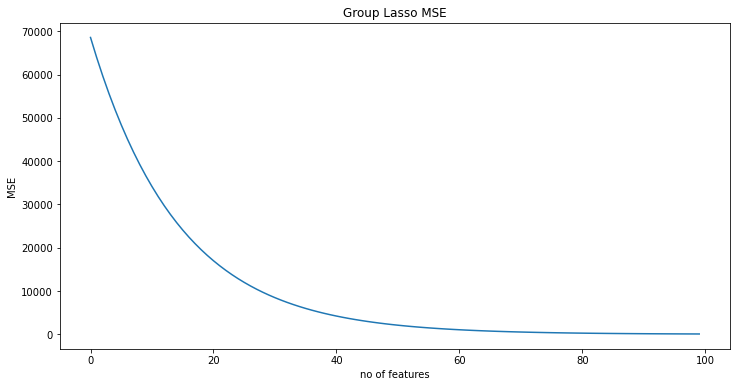

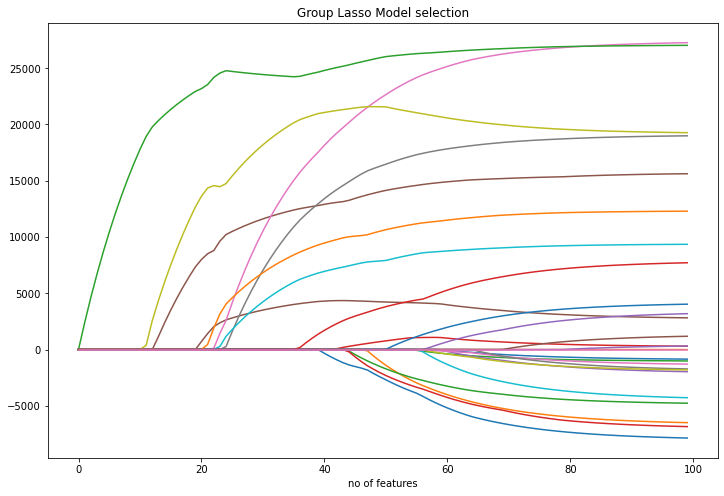

In [9]:
from sklearn.model_selection import GridSearchCV
from group_lasso import GroupLasso
import sklearn.linear_model as lm

group = sum([[i]*10 for i in range(1, 101)], [])
lambdas, lasso_betas, _ = lm.lasso_path(Bcoef, y)

fig, ax = plt.subplots(figsize=(12, 6))
plt.plot(lambdas)
plt.xlabel("no of features")
plt.ylabel("MSE")
plt.title("Group Lasso MSE")
plt.show()

fig, ax = plt.subplots(figsize=(12, 8))
plt.xlabel("no of features")
plt.title("Group Lasso Model selection")
plt.plot(lasso_betas.T)
plt.show()


In [10]:
lasso_betas.T.shape

(100, 27)

## Use Linear Regression

In [11]:
from sklearn.linear_model import LinearRegression
X_train, X_test, y_train, y_test = train_test_split(Bcoef,y, test_size=0.20, random_state=25)
reg = LinearRegression().fit(X_train, y_train)
print(f"Training Score {reg.score(X_train, y_train)}")
print(f"Test Score {reg.score(X_test, y_test)}")
print(np.sqrt(max_error(reg.predict(X_train), y_train)))
print(np.sqrt(max_error(reg.predict(X_test), y_test)))

Training Score 0.7443790778891382
Test Score 0.767281064431768
674.144791883658
593.2893407431974


## Use Lasso

In [12]:
import warnings
import time
warnings.filterwarnings("ignore")

X_train, X_test, y_train, y_test = train_test_split(Bcoef,y, test_size=0.20, random_state=25)

from sklearn.linear_model import LassoCV
reg = LassoCV(cv=10, random_state=3).fit(X_train, y_train)
print(f"Training Score {reg.score(X_train, y_train)}")
print(f"Test Score {reg.score(X_test, y_test)}")
print(np.sqrt(max_error(reg.predict(X_train), y_train)))
print(np.sqrt(max_error(reg.predict(X_test), y_test)))


Training Score 0.7424736039194467
Test Score 0.7660866413966565
671.4955832746994
596.880391563836


## No Luck with decomposed objects, score around 80%, 
## Next try using Lasso for feature selection

In [13]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import StandardScaler, MinMaxScaler, Normalizer,OrdinalEncoder

scaler = MinMaxScaler()

X_train, X_test, y_train, y_test = train_test_split(scaler.fit_transform(train_scaled),y,\
                                                    test_size=0.20, random_state=25)
selector = SelectFromModel(estimator=LassoCV(eps=0.001))\
            .fit(X_train,y_train)

print(selector.estimator_.coef_)

[-0.00000000e+00  0.00000000e+00 -1.14642054e+02 -3.88711063e+03
  4.10699762e+03  0.00000000e+00  0.00000000e+00  1.56501076e+04
  7.82649034e+03  0.00000000e+00 -0.00000000e+00 -7.53707631e+03
 -0.00000000e+00  1.32418160e+03  2.58459509e+04 -5.01221941e+03
 -0.00000000e+00  4.59459523e+03 -3.92811838e+04  0.00000000e+00
  0.00000000e+00 -2.15476982e+04  1.58618931e+04 -5.42921331e+03
 -7.42207499e+03  4.36541256e+03 -0.00000000e+00 -4.21074105e+03
  9.79480369e+03  0.00000000e+00 -2.99917220e+04  1.59082897e+04
 -3.80784795e+03 -3.11256954e+03 -8.05355997e+03  0.00000000e+00
  0.00000000e+00  3.50471252e+03 -2.93851152e+04 -0.00000000e+00
 -0.00000000e+00 -1.22286977e+03  1.48806980e+04 -1.91156014e+04
 -0.00000000e+00  0.00000000e+00  1.22488645e+05  1.81721689e+04
  3.43476673e+04  0.00000000e+00  0.00000000e+00  0.00000000e+00
  1.20791546e+04  2.09352446e+04  0.00000000e+00 -0.00000000e+00
  1.51479069e+05  2.81044975e+04  3.35785300e+02  1.80011653e+04
  3.82491151e+03 -0.00000

In [14]:
X_train_lasso = pd.DataFrame(X_train.copy())
selected_feat = X_train_lasso.columns[(selector.get_support())]
print('total features: {}'.format((X_train_lasso.shape[1])))
print('selected features: {}'.format(len(selected_feat)))
print('features with coefficients shrank to zero: {}'.format(\
np.sum(selector.estimator_.coef_ == 0)))

total features: 75
selected features: 43
features with coefficients shrank to zero: 32


In [15]:
removed_feats = X_train_lasso.columns[(selector.estimator_.coef_ == 0).ravel().tolist()]
train.columns[removed_feats]

Index(['MSSubClass', 'MSZoning', 'Alley', 'LotShape', 'LotConfig', 'LandSlope',
       'Condition1', 'OverallQual', 'RoofMatl', 'Exterior1st', 'Foundation',
       'BsmtExposure', 'TotalBsmtSF', 'Heating', 'Electrical', '1stFlrSF',
       'BsmtFullBath', 'BsmtHalfBath', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'FireplaceQu', 'GarageType', 'GarageCond', 'PavedDrive',
       'EnclosedPorch', 'ScreenPorch', 'PoolQC', 'Fence', 'MiscFeature',
       'SaleType', 'SaleCondition'],
      dtype='object')

In [16]:
X_train_selected = selector.transform(X_train)
X_test_selected = selector.transform(X_test)
print(X_train_selected.shape, X_test_selected.shape)

(1168, 43) (292, 43)


In [17]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score,max_error,RocCurveDisplay

reg = LinearRegression().fit(X_train_selected, y_train)
print(f"Training Score {reg.score(X_train_selected, y_train)}")
print(f"Test Score {reg.score(X_test_selected, y_test)}")
print(np.sqrt(max_error(reg.predict(X_train_selected), y_train)))
print(np.sqrt(max_error(reg.predict(X_test_selected), y_test)))


Training Score 0.845074425871076
Test Score 0.8237018007305353
561.9701329255745
594.2532477678604
